# Assistant de recherche et de synthèse d'articles scientifiques

L’objectif de ce projet est de concevoir un assistant capable d’effectuer des recherches sur des articles scientifiques, en identifiant les publications les plus pertinentes, puis en générant une synthèse de chacun d’eux afin de fournir une réponse claire et structurée.
Le graphe prend la question en français, la traduit en anglais, interroge automatiquement plusieurs sources (Tavily, Arxiv, PubMed) selon la requête, puis synthétise les résultats pour fournir une réponse finale claire.

In [18]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_tavily import TavilySearch
from langchain_community.retrievers import ArxivRetriever
from langchain_community.retrievers import PubMedRetriever
from typing import List, TypedDict, Annotated
import operator
import os
from dotenv import load_dotenv


In [19]:
load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
KEY_API= os.getenv("GROQ_API_KEY")

In [35]:
llm = ChatGroq(model = "openai/gpt-oss-120b", temperature=0)

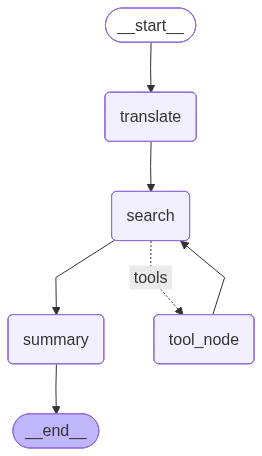

In [55]:
class AgentState(TypedDict):

    messages: Annotated[List[AnyMessage], operator.add]

@tool
def tavily(message):
    """Moteur de recherche général en ligne en temps réel
    
    Args:
       message: la requête de l'utilisateur"""
    
    tavily = TavilySearch(max_results = 5, topic = "general", include_answer = True)

    return tavily.invoke({"query": message})

@tool
def arxiv(message):
    """Acceder à des articles dans le domaine de la science
    
    Args:
       message: la requête de l'utilisateur
    """

    arxiv = ArxivRetriever(
    load_max_docs=5,
    get_ful_documents=True)

    return arxiv.invoke(message)

@tool 
def pubmed(message):
    """Accéder à des citations dans le domaine de la medecine
    
    Args: 
       message: la requête de l'utilisateur"""
    
    pubmed = PubMedRetriever()

    return pubmed.invoke(message)

    
tools = [tavily, arxiv, pubmed]

llm_with_tools = llm.bind_tools(tools)

def translate(state):

    state["messages"] = [llm.invoke([SystemMessage(content="Tu es un traducteur francais -> anglais tu ne réponds pas à la question posée")] + state["messages"])]

    return state

def search(state):

    state["messages"] = [llm_with_tools.invoke(state["messages"])]

    return state

def summarize(state):

    state["messages"] = [llm_with_tools.invoke([SystemMessage(content="Tu es un spécialiste en synthèse de documents")] + state["messages"])]

    return state



def use_tool(state):

    if state["messages"][-1].tool_calls:

        return "tools"
    
    return "summary"

graph = StateGraph(AgentState)

graph.add_node("translate", translate)
graph.add_node("search", search)
graph.add_node("summary", summarize)
tool_node = ToolNode(tools)
graph.add_node("tool_node", tool_node)
graph.add_conditional_edges("search", use_tool,
                            {"tools": "tool_node",
                             "summary": "summary"})
graph.add_edge("tool_node", "search")
graph.add_edge("translate", "search")
graph.add_edge("search", "summary")
graph.add_edge(START, "translate")
graph.add_edge("summary", END)

app = graph.compile()

app

In [56]:
response = app.invoke({"messages": [HumanMessage(content = "Quels sont les dernières avancées en intelligence artificielle ?")]})
print(response["messages"][-1].content)

**Les dernières avancées en intelligence artificielle (2023‑2025)**  

| Domaine | Avancées majeures | Impact / Applications | Sources |
|---------|-------------------|-----------------------|---------|
| **Modèles de fondation multimodaux** | • Lancement de modèles capables de traiter texte, image, audio et vidéo dans un même prompt (ex. **GPT‑4o**, **Claude 3.5**, **Gemini 1.5 Pro**).<br>• Architecture « sparse‑expert » qui n’active que les sous‑réseaux pertinents, réduisant le coût d’inférence de 30‑50 % tout en conservant la qualité. | Assistants plus polyvalents (ex. génération de code à partir d’une capture d’écran), IA utilisable sur des appareils edge. | 【1†L0-L3】 |
| **Apprentissage efficace & durabilité** | • Techniques de fine‑tuning légères (LoRA, AdapterFusion) qui adaptent un LLM avec quelques milliers d’exemples, diminuant la consommation énergétique de ~80 %.<br>• Quantisation 4‑bit et pruning dynamique intégrés aux SDK NVIDIA/AMD, permettant d’exécuter des modèles de 7

In [57]:
for r in response["messages"]:

    r.pretty_print()

================================ Human Message =================================

Quels sont les dernières avancées en intelligence artificielle ?
================================== Ai Message ==================================

What are the latest advances in artificial intelligence?
================================== Ai Message ==================================
Tool Calls:
  tavily (fc_23c3cc31-338a-441a-92b1-f0b3f98342ab)
 Call ID: fc_23c3cc31-338a-441a-92b1-f0b3f98342ab
  Args:
    message: latest advances in artificial intelligence 2024 2025
================================== Ai Message ==================================
Tool Calls:
  tavily (fc_f9cf5583-3c22-4149-9ccb-5582426098a9)
 Call ID: fc_f9cf5583-3c22-4149-9ccb-5582426098a9
  Args:
    message: latest advances in artificial intelligence 2024
================================= Tool Message =================================
Name: tavily

{"query": "latest advances in artificial intelligence 2024 2025", "follow_up_questions":